In [1]:
#from shutil import copy
#from shutil import copyfile
import os
import sys
import cv2 as cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from os import walk
import IPython
#IPython.embed() # to debug in notebook
import random
import math
print("Successfully imported all")

Successfully imported all


In [2]:
input_file = "preprocess.jpg"
if os.path.isfile(input_file) == False:
    print("Input file: ", input_file, " not found")
    assert False
input_file_2 = "preprocess_2.jpg"
if os.path.isfile(input_file_2) == False:
    print("Input file: ", input_file_2, " not found")
    assert False
    

# Post process

In [3]:
# HSV ranges (THESE ARE HSV VALUES)
lower_blu = np.array([118, 240, 10]) 
upper_blu = np.array([122, 255, 255])

lower_red = np.array([0, 240, 10]) 
upper_red = np.array([6, 255, 255])

lower_grn = np.array([54, 240, 10]) 
upper_grn = np.array([66, 255, 255])

lower_cya = np.array([84, 240, 10]) 
upper_cya = np.array([96, 255, 132])

                                #   Blue Green Red
test_hsv = cv2.cvtColor( np.uint8([[[128,128,0]]] ), cv2.COLOR_BGR2HSV)[0][0]
print(test_hsv)  

[ 90 255 128]


In [4]:
# Function of lane width varied over height
# May need to fidget with this if the resolution differernt than CULane
def lane_width_px(y):
    if y <= 260:
        return 1
    return (int) (y * 0.1 - 25)

In [5]:
# @each row in @points should be of form (x,y)
# @lane_number is the number to be placed in the grayscale image, which represents the class of the lane line
# @points should be going from the top of the image downwards, the drawing will stop when the lane line goes off screen
def draw_lane(img, points, lane_number):
    # Draw a line in for each point
    for i in range(points.shape[0]):
        point = points[i, :]
        lane_width = lane_width_px(point[1])
        if point[1] < 0 or point[1] > img.shape[0] or point[0] < lane_width // 2 or point[0] > img.shape[1] + lane_width // 2:
            return
        cv2.line(img, (point[0] - lane_width // 2, point[1]), (point[0] + lane_width // 2, point[1]), lane_number, 1) # Thickness = 1

In [6]:
# @point should be (x,y) form of point, top left corner is origin point
# @ width, height should be the height and width of the frame
def angle_from_top_center(point, width, height):
    dx = (width / 2) - point[0]
    dy = point[1] - 0.25 * height   # Take center point y dimension to be closer to vanishing point
    return math.atan2(dy, dx)

In [7]:
# Need more points, because poly is overfitting
ORDER = 3
Y_POLY_POINT_STEP = 1
EXTEND_LANE_DOWN_BY = 300

lane_colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [0, 255, 255], [255, 255, 0], [255, 0, 255], [255, 255, 255]]

def post_process_output(mask):
    # Threshold different color lines out
    mask_hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)    # Convert to HSV
    # Get each lane
    red_res = cv2.inRange(mask_hsv, lower_red, upper_red)
    blu_res = cv2.inRange(mask_hsv, lower_blu, upper_blu)  
    grn_res = cv2.inRange(mask_hsv, lower_grn, upper_grn)  
    cya_res = cv2.inRange(mask_hsv, lower_cya, upper_cya)  
    
    lanes = [{"color": "red", "lane": red_res}, {"color": "blue", "lane": blu_res}, 
             {"color": "green", "lane": grn_res}, {"color": "cyan", "lane": cya_res}]

    # Get centers first
    for i in range(len(lanes)):
        lane = lanes[i]["lane"]
        M = cv2.moments(lane)
        # calculate x,y coordinate of center
        if M["m00"] == 0:
                lanes[i]["center"] = None
                lanes[i]["DNE"] = True
        else:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            #cv2.circle(lane, (cX, cY), 40, [255], -1)
            lanes[i]["center"] = (cX, cY)
    
    # Get angles
    for i in range(len(lanes)):
        if "DNE" not in lanes[i].keys():
            lanes[i]["angle"] = angle_from_top_center(lanes[i]["center"], mask.shape[1], mask.shape[0])
        else:
            lanes[i]["angle"] = 0    # Assume left most lane
    
    # Sort the lanes according to the angle between the centers of each lane and the top center
    def sort_by_angle(d):
        return d["angle"]
    lanes = sorted(lanes, key = sort_by_angle)
        
    post_processed = np.zeros((lanes[0]["lane"].shape[0], lanes[0]["lane"].shape[1], 3), np.uint8)
    # Calculate 6th order polynomial for each
    for i in range(len(lanes)):
        if "DNE" in lanes[i].keys():
            continue
        points = np.argwhere(lanes[i]["lane"] != 0)
        # Polynomial regression, Evaluate polynomial, Draw polynomial
        if points.shape[0] > 0:
            coeefs = np.polyfit(points[:,0], points[:,1], ORDER)  # As a function of Y
            y_vals = list(range(min(points[:,0]), max(points[:,0]) + EXTEND_LANE_DOWN_BY, Y_POLY_POINT_STEP))
            x_vals = [np.polyval(coeefs, y) for y in y_vals]
            poly_points = np.int32( np.column_stack((x_vals, y_vals)) )
            # Draw the polynomial
            draw_lane(post_processed, poly_points, lane_colors[i])
    
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)   # So we can see it properly when plotting
    #cv2.circle(mask, (mask.shape[1] // 2, int(mask.shape[0] * 0.25)), 20, [255], -1)
    
    #plt.rcParams["figure.figsize"] = (20,10)
    #f, axs = plt.subplots(3, 2)
    #for _, ax in np.ndenumerate(axs):   # Remove axes
    #    ax.axis('off')
    #axs[0][0].imshow(mask)
    #axs[0][1].imshow(post_processed)
    #axs[1][0].imshow(blu_res, cmap='gray')
    #axs[1][1].imshow(red_res, cmap='gray')
    #axs[2][0].imshow(grn_res, cmap='gray')
    #axs[2][1].imshow(cya_res, cmap='gray')
    #plt.tight_layout()
    #plt.show()
    return post_processed

# Plot results

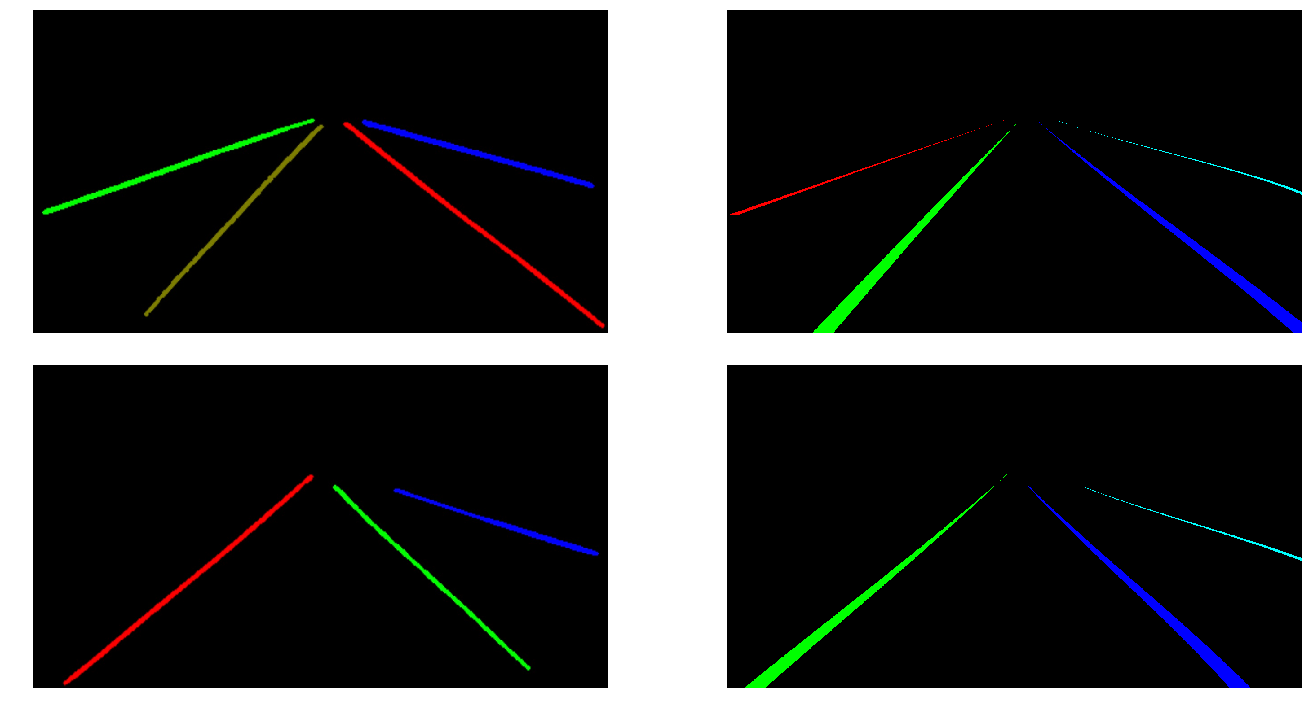

In [8]:
pre_processed_img = cv2.imread(input_file)
post_process = post_process_output(pre_processed_img)

pre_processed_img_2 = cv2.imread(input_file_2)
post_process_2 = post_process_output(pre_processed_img_2)

plt.rcParams["figure.figsize"] = (20,10)
f, axs = plt.subplots(2, 2)
for _, ax in np.ndenumerate(axs):   # Remove axes
    ax.axis('off')
axs[0][0].imshow(pre_processed_img)
axs[0][1].imshow(post_process)
axs[1][0].imshow(pre_processed_img_2)
axs[1][1].imshow(post_process_2)
plt.tight_layout()
plt.show()